# Krigging

In [1]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging
import datetime as dt

from _modules.plotColors import *
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter, DayLocator

file_name: str = "_00-Krigging"
filepath_dir: str =os.path.join(r"C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report", file_name)

 ### test init### 


### Preprocessing

In [2]:
# -------------------------------------------------------------------------------------------
# Load the weather data into a coherent dataframe for each environmental variable
#
# -------------------------------------------------------------------------------------------

def LoadWeatherStationDataIntoDf(item: str, dirs: List[str] = []) -> pd.DataFrame:

    df_list = []
    for file_dir in dirs:
        filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
        for weather_file in filepaths:
            #print(weather_file)
            filename = os.path.basename(weather_file)
            station_name = filename.split('_')[1]
            df = pd.read_csv(weather_file)
            df = df[['Datetime', item]]
            df.rename(columns={item: f"{station_name}_{item}"}, inplace=True)

            df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S')
            df = df.drop_duplicates('Datetime') #Sure?
            df.set_index('Datetime', inplace=True)
            
            df_list.append(df)

    combined_df = pd.concat(df_list, axis=1, join='outer')
    combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
    return combined_df


dirs = [r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202402\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202403\EveryMinute']

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_relH_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
WS_Rad_df = LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', dirs)
# WS_Wspeed_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
# WS_WDir_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)

start_date = '2024-01-01'
end_date = '2024-03-15'
WS_Temp_filtered_df = WS_Temp_df.loc[start_date:end_date]

#display(WS_Temp_filtered_df.columns)


C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\208243368.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\208243368.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\208243368.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()


In [3]:
# -------------------------------------------------------------------------------------------
# Load the weather station data and adjust it to meters and compute the relevenant features
#
# -------------------------------------------------------------------------------------------

from pyproj import Proj, transform
from scipy.spatial.distance import cdist

parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirOut: str = r'Esse\report\krigging_output'

griddf = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)

WS_df = pd.read_csv(os.path.join(parent_dir, 'WS_features_updated.csv'))
wgs84 = Proj(init='epsg:4326') 
utm = Proj(init='epsg:3414')   

def convert_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

WS_df['X'], WS_df['Y'] = convert_to_meters(WS_df['Lon'], WS_df['Lat'])


def add_closest_grid_info(WS_df, griddf, columns=['distToTree', 'distToCarpark']):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argmin(distances, axis=1)
    
    closest_info = griddf.iloc[closest_indices][columns].reset_index(drop=True)
    
    closest_info['reference'] = closest_indices
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), closest_info], axis=1)
    
    return WS_df, closest_indices.tolist()

def add_closest_grid_info_multiple(WS_df, griddf, columns=['distToTree', 'distToCarpark'], num_closest=5):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argsort(distances, axis=1)[:, :num_closest]
    
    averaged_values = {col: [] for col in columns}
    
    for indices in closest_indices:
        closest_data = griddf.iloc[indices][columns]
        for col in columns:
            averaged_values[col].append(closest_data[col].mean())
    
    averaged_info = pd.DataFrame(averaged_values)
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), averaged_info], axis=1)
    unique_reference_values = np.unique(closest_indices.flatten()).tolist()
    return WS_df, unique_reference_values

selection = ['distToBuilding', 'distToTree', 'distToCarpark', 'distToCourtTrack', 'distToPath', 'distToRoad', 'distToWalkway', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height']
modified_WS_df, reference_values = add_closest_grid_info_multiple(WS_df, griddf, columns=selection, num_closest=5)

print(reference_values)
# display(WS_df.head(10))
# display(griddf.head(10))

selected_rows = griddf.loc[reference_values]
new_df = pd.DataFrame(selected_rows)
def convert_to_lon_lat(x, y):
    lon, lat = transform(utm, wgs84, x, y)
    return lon, lat


new_df['Lon'], new_df['Lat'] = convert_to_lon_lat(new_df['X'], new_df['Y'])
griddf['Lon'], griddf['Lat'] = convert_to_lon_lat(griddf['X'], griddf['Y'])

#display(modified_WS_df.head(5))
print(modified_WS_df.columns)
display(modified_WS_df)
general           = ['X', 'Y', 'Lat', 'Lon', 'Shortname']
terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark'] #'distToBuilding'

features = general + distance_features + sky_features   + veg_features  + bld_features + terrain_features

kriging_ws_df = modified_WS_df[features]

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\1875879072.py:19: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/got

[1191, 1192, 1229, 8993, 8994, 9032, 9033, 9069, 10509, 10510, 10536, 10537, 10563, 10610, 10611, 10637, 10638, 10665, 11459, 11470, 11471, 11483, 11484, 11619, 11620, 11627, 11628, 12914, 19006, 19007, 19008, 19121, 19122, 20097, 20133, 20194, 20195, 20230, 20231, 20292, 20293, 20328, 20329, 21708, 21777, 21778, 21779, 21846, 22115, 22116, 22181, 22182, 22252, 23135, 23184, 23185, 23186, 23236, 26304, 26343, 26344, 26382, 26383, 27091, 27092, 27142, 27143, 27194, 27386, 27450, 27451, 27528, 27529, 28569, 28570, 28571, 28659, 28660, 28813, 28814, 28815, 28905, 28906, 29381, 29473, 29474, 29475, 29565, 30229, 30230, 30295, 30296, 30297, 32835, 32938, 32939, 32940, 33044, 33234, 33344, 33345, 33346, 33457, 33575, 33690, 33691, 33692, 33715, 33716, 33808, 33817, 33818, 33819, 33831, 33832, 33833, 33934, 33935, 34384, 34385, 34498, 34499, 34613, 34923, 34924, 35034, 35035, 35036, 37807, 38357, 38358, 38401, 38402, 38433, 38434, 38477, 38478, 38479, 38508, 39059, 39060, 39100, 39101, 39138,

C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\1875879072.py:66: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)
C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\1875879072.py:66: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)


Number/file name in AWS Reflected in Google Map to NUS President  \
0                       76                                        1   
1                       60                                        2   
2                       62                                        3   
3                        3                                        4   
4                       75                                        5   
5                       73                                        6   
6                       61                                        7   
7                       29                                        8   
8                       25                                        9   
9                       11                                       10   
10                       6                                       11   
11                      72                                       12   
12                      48                                       13   
13                      42                                       14   
14                      33                                       15   
15                      67                                       16   
16                      32                                       17   
17                      31                                       18   
18                       9                                       19   
19                      47                                       20   
20                      36                                       21   
21                      13                                       22   
22                      65                                       23   
23                      14                                       24   
24                      18                                       25   
25                      39                                       26   
26                      24                                       27   
27                      50                                       28   
28                      37                                       29   
29                      68                                       30   
30                      17                                       31   
31                      69                                       32   
32                      16                                       33   
33                      56                                       34   
34                      77                                       35   
35                      43                                       36   
36                      74                                       37   
37                      45                                       38   
38                      57                                       39   
39                      44                                       40   
40                     E1A                                        X   
41                     KRR                                        Y   
42                     MD1                                        Z   

                    Type                                           Longname  \
0        Weather station                      Lamp post - CP2A in front E3A   
1        Weather station                              Roof - E1A upper roof   
2        Weather station                      Lamp post - in between E2-E1A   
3        Weather station                               Railing - E1 level 2   
4        Weather station                              Railing - next to EW1   
5        Weather station                                       Roof - SDE3    
6        Weather station                        Column - shelter next to E8   
7        Weather station        Lamp post - U-Turn in front of LKCNH Museum   
8        Weather station                         Lamp post - roundabout YIH   
9        Weather station                        Lamp post - bus stop NUS IT   
10       

In [4]:
# -------------------------------------------------------------------------------------------
# Display the gridcells and waether stations
#
# -------------------------------------------------------------------------------------------
#TODO ADJUST THIS PLOT LATER FOR PRESENTATION

fig = go.Figure()

# Add WS_df markers in blue
fig.add_trace(
    go.Scattermapbox(
        lat=WS_df['Lat'],
        lon=WS_df['Lon'],
        mode='markers',
        marker=dict(
            size=4,
            color='blue',
            opacity=0.7
        ),
        name='WS_df'
    )
)

# Add new_df markers in red (larger) with square symbol
fig.add_trace(
    go.Scattermapbox(
        lat=griddf['Lat'],
        lon=griddf['Lon'],
        mode='markers',
        marker=dict(
            size=3,
            color='grey',
            opacity=0.7
        ),
        name='grid_df'
    )
)

# Highlight specified indices in red
fig.add_trace(
    go.Scattermapbox(
        lat=griddf.loc[reference_values, 'Lat'],
        lon=griddf.loc[reference_values, 'Lon'],
        mode='markers',
        marker=dict(
            size=4,
            symbol='circle', 
            color='red',
            opacity=0.7,
        ),
        name='highlighted_points'
    )
)


fig.update_layout(
    mapbox=dict(
        style="carto-positron",  # Set the style to "carto-positron" for grey
        center=go.layout.mapbox.Center(
            lat=griddf['Lat'].mean(),  # Center the map on mean latitude
            lon=griddf['Lon'].mean(),  # Center the map on mean longitude
        ),
        zoom=14,  # Adjust the zoom level as needed
    ),
    legend=dict(
        title="Region Status",
    ),
    width=800,  # Adjust the width of the plot
    height=800,  # Adjust the height of the plot
    title="Referenced Location Points taken for WS df definitions",
)

fig.show()
#--------------------------------------------------------------


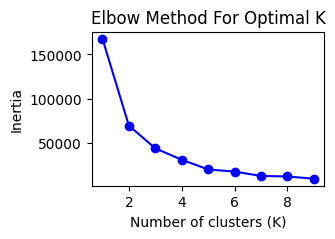

Cluster  Bld_percent_min  Bld_percent_max  Bld_percent_mean  \
0        0         0.000000         0.000000          0.000000   
1        1         0.000000         5.474783          0.557870   
2        2         3.513083        52.015696         23.592887   
3        3         0.000000        34.938296          2.915190   
4        4        99.757373       100.000000         99.878687   

   Veg_percent_min  Veg_percent_max  Veg_percent_mean  Bld_SkyEx_min  \
0         0.000000        48.610781         18.340391       0.662165   
1         0.000000        14.109461          1.417642      66.122865   
2         0.000000         0.000000          0.000000      48.232014   
3        55.684077       100.000000         86.369434       0.000000   
4         0.000000         0.000000          0.000000      50.036723   

   Bld_SkyEx_max  Bld_SkyEx_mean  Veg_SkyEx_min  Veg_SkyEx_max  \
0      36.140558       12.296695      58.131688      85.374782   
1      90.641306       79.218697      53.791962      89.526386   
2      81.119623       65.944602       2.899949      51.763680   
3      40.094959       14.690335      69.248286      97.782275   
4      86.688316       68.362520       0.000000       6.516523   

   Veg_SkyEx_mean  Sun_h_min  Sun_h_max  Sun_h_mean  
0       70.259417        0.0        5.6    1.628571  
1       73.251470        7.4       11.0   10.200000  
2       26.046424        7.6       12.0   10.566667  
3       84.407292        0.0        7.0    2.100000  
4        3.258261        8.6       11.2    9.900000

In [5]:
# -------------------------------------------------------------------------------------------
# Cluster the Weather stations by common features, redescribe them and make plots
#
# -------------------------------------------------------------------------------------------

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = modified_WS_df.copy()

features = df[['Bld_percent', 'Veg_percent', 'Bld_SkyEx', 'Veg_SkyEx', 'Sun_h']]

# Determine the optimal number of clusters using the Elbow Method
inertia = []
K = range(1, 10)  # Range of number of clusters to try
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(3, 2))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

# Based on the elbow plot, choose the optimal number of clusters
optimal_k = 5  # Replace this with the optimal number of clusters determined from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(features)

# Add the cluster labels to the original dataframe
df['Cluster'] = kmeans.labels_
withCluster_WS_df = df.copy()

fig_clustered = go.Figure()
# Create a color palette for clusters
palette = px.colors.qualitative.Plotly

# Add scatter mapbox traces for each cluster
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    fig_clustered.add_trace(
        go.Scattermapbox(
            lat=cluster_data['Lat'],
            lon=cluster_data['Lon'],
            mode='markers',
            marker=dict(
                size=8,
                color=palette[cluster],  # Use color from the palette
                opacity=0.7
            ),
            name=f'Cluster {cluster}'
        )
    )


fig_clustered.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":40,"l":0,"b":0},
    height=600,
    mapbox=dict(
        center=go.layout.mapbox.Center(
            lat=df['Lat'].mean(),
            lon=df['Lon'].mean()
        ),
        zoom=14
    ),
    title="Geographical Clustering of Weather Stations"
)

fig_clustered.show()

# -------------------------------------------------------------------------------------------
# Describe the cluster features
#
# -------------------------------------------------------------------------------------------
aggregation_functions = {feature: ['min', 'max', 'mean'] for feature in features.columns}
cluster_stats = df.groupby('Cluster').agg(aggregation_functions)

# Flatten the MultiIndex columns and create new column names
cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

# Reset index to turn the grouped DataFrame back into a regular DataFrame
cluster_stats.reset_index(inplace=True)

display(cluster_stats)

#add a column with renamed clusters


### Linecharts

In [6]:
def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    df = WS_Temp_df.resample('1H').mean()

    # Calculating min, max, and mean values for each hour
    min_values = df.min(axis=1)
    max_values = df.max(axis=1)
    mean_values = df.mean(axis=1)

    # Creating a new DataFrame with these values
    stats_df = pd.DataFrame({
        'Time': df.index,
        'Min': min_values,
        'Max': max_values,
        'Mean': mean_values
    })

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Shading the area between min and max
    plt.fill_between(stats_df['Time'], stats_df['Min'], stats_df['Max'], color='grey', alpha=0.5, label='Min-Max Range', linewidth=0.01)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='grey', alpha=0.15, label='Study Period')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='grey', alpha=0.15, label='Study Period')

    # Plotting the mean values as a thin red line
    sns.lineplot(data=stats_df, x='Time', y='Mean', color=highlightColor, label='Mean (Hourly)', linewidth=1)

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=1)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: Min, Max, and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_AirTemperature.png


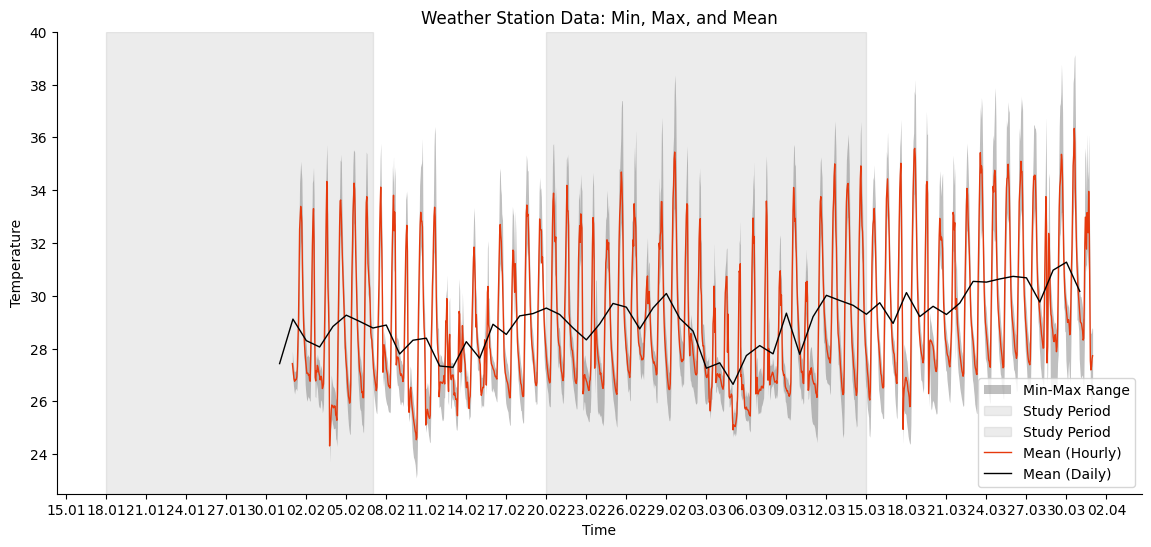

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_RelHumidity.png


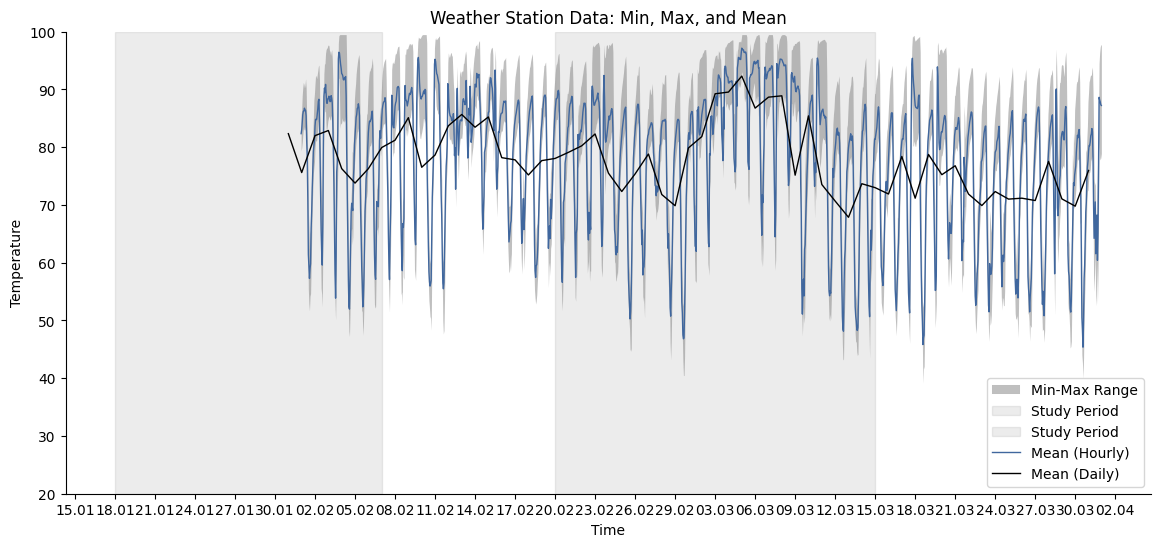

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_RelHumidity.png


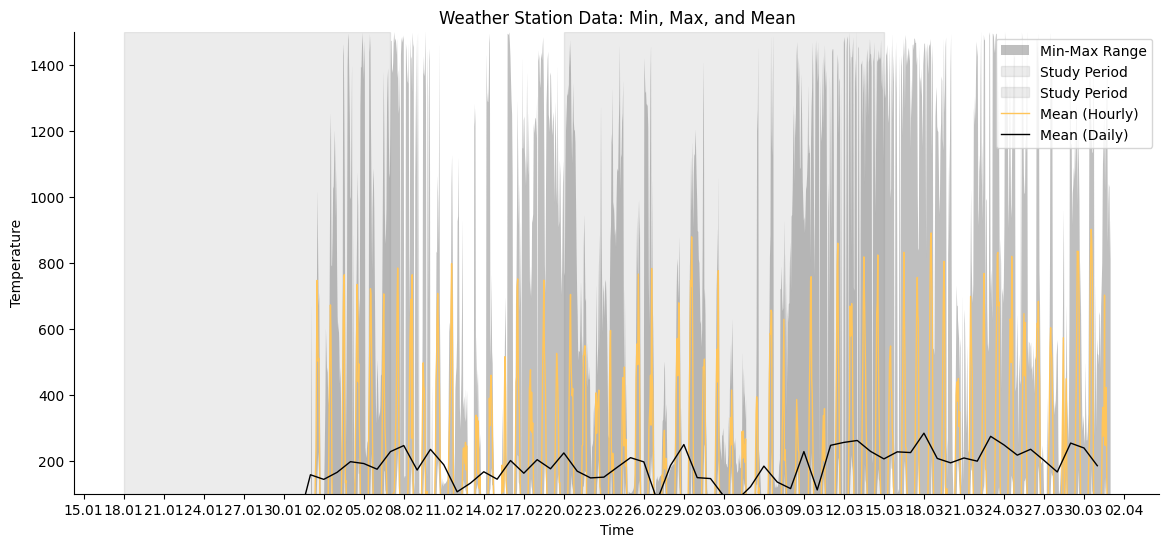

In [7]:
plot_weather_station_data(WS_Temp_df, filepath_dir, "Linechart_AirTemperature.png", color_vulcanfire, 22.5, 40)

plot_weather_station_data(WS_relH_df, filepath_dir, "Linechart_RelHumidity.png", cBlue, 20, 100)
plot_weather_station_data(WS_Rad_df, filepath_dir, "Linechart_RelHumidity.png", cYellow, 100, 1500)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.dates import DateFormatter, DayLocator

def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    df = WS_Temp_df.resample('1H').mean()

    # Calculating min, max, and mean values for each hour
    mean_values = df.mean(axis=1)

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Plotting all values as points
    for col in WS_Temp_df.columns:
        sns.scatterplot(data=WS_Temp_df, x=WS_Temp_df.index, y=WS_Temp_df[col], color='blue', alpha=0.3, label='_nolegend_', s=0.1)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='grey', alpha=0.15, label='Study Period')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='grey', alpha=0.15)

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=1)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: All Values and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()


Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\test.png


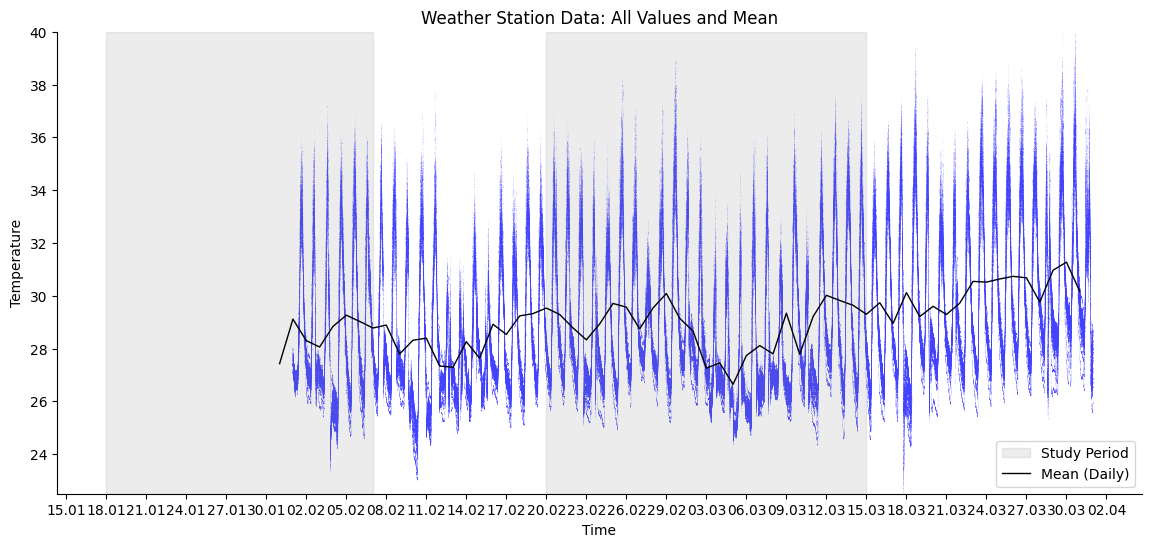

In [9]:
highlightColor = 'red'
minimum = 22.5
maximum = 40
Name = 'test.png'

df = WS_Temp_df.resample('h').mean()

plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum)

C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\1931919520.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\1931919520.py:80: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Boxchart_AirTemperaturewithTotalValues_Day.png


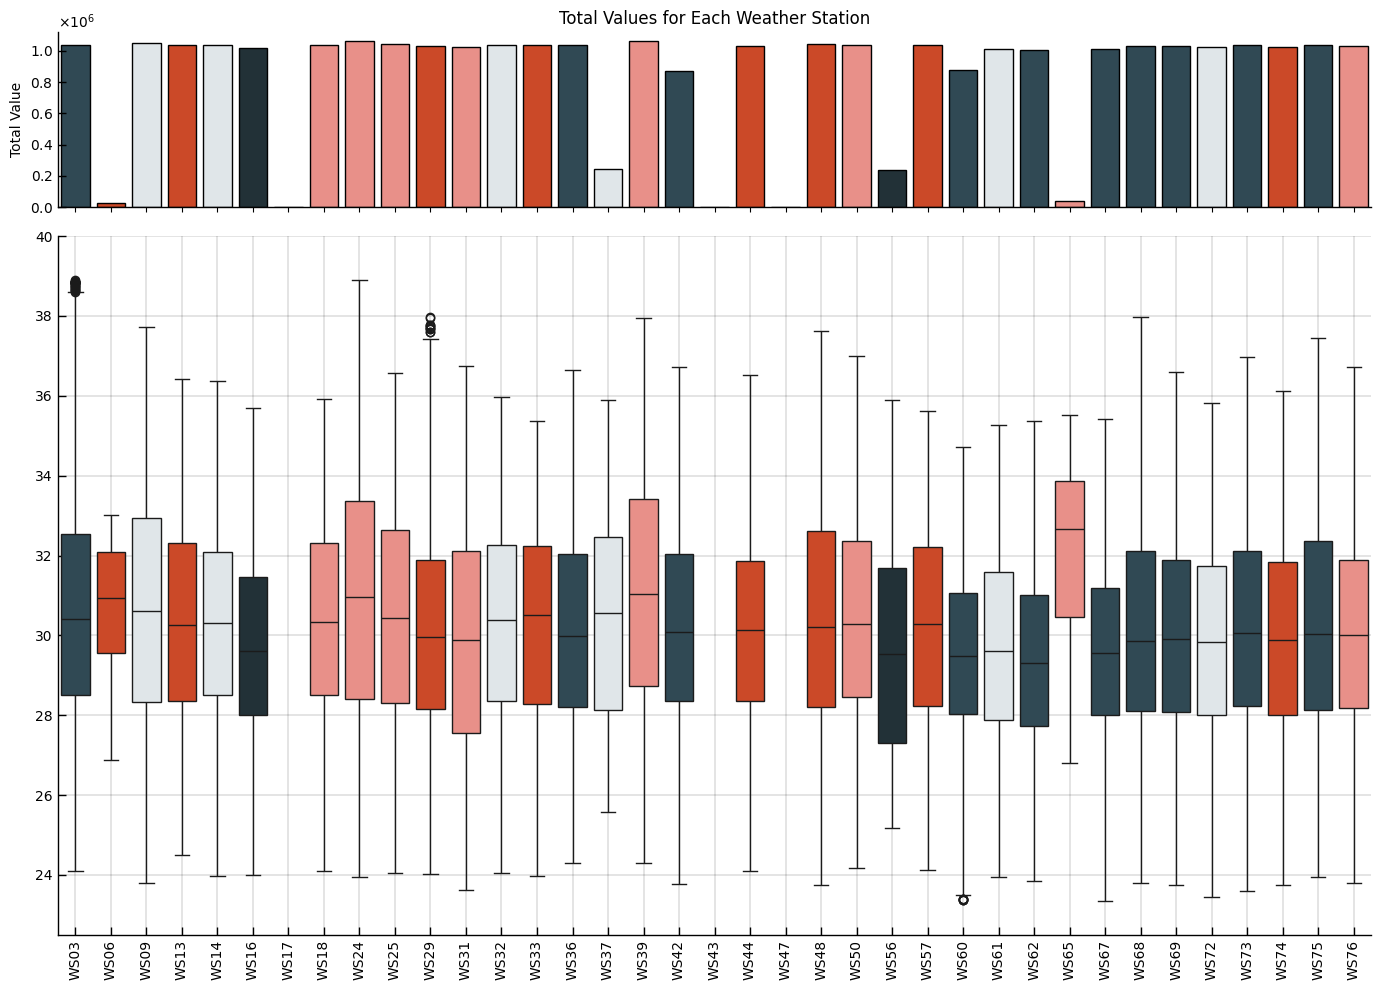

In [10]:
# -------------------------------------------------------------------------------------------
# Plot the boxplots
#
# -------------------------------------------------------------------------------------------

# Assume color_citylights, color_coralpink, color_vulcanfire, color_deepseablue, and color_elderberryblack are predefined color values.

# Create the cluster info DataFrame
# WS_Temp_filtered_df.index = pd.to_datetime(WS_Temp_filtered_df.index)

# Filter based on the hour
filtered_df = WS_Temp_filtered_df[(WS_Temp_filtered_df.index.hour > 7) & (WS_Temp_filtered_df.index.hour < 21)]

# Optionally rename columns
filtered_df.columns = [col.split('_')[0] for col in filtered_df.columns]

df = filtered_df
# Create a dictionary for the cluster values
cluster_dict = dict(zip(withCluster_WS_df['Shortname'], withCluster_WS_df['Cluster']))

# Predefined color map for clusters
predefined_colors = {0: color_citylights, 1: color_coralpink, 2: color_vulcanfire, 3: color_deepseablue, 4: color_elderberryblack}

# Generate a color palette with distinct colors for each unique cluster
unique_clusters = sorted(set(cluster_dict.values()))
palette = sns.color_palette("husl", len(unique_clusters))
color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Update the color map with predefined colors
color_map.update(predefined_colors)

# Map colors to the columns in the DataFrame based on the cluster
column_colors = [color_map[cluster_dict.get(col, 0)] for col in df.columns]

# Calculate total values
total_values = df.sum()

# Create subplots
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 4]})

# Bar plot on the first axis
bar = sns.barplot(x=total_values.index, y=total_values.values, ax=ax1, palette=column_colors)

# Customize bar plot aesthetics
ax1.set_title('Total Values for Each Weather Station')
ax1.set_ylabel('Total Value')
ax1.set_facecolor('white')
ax1.set_xticklabels([])  # Remove x-tick labels
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(1)
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='y', direction='in', length=6, width=1, colors='black')

ax1.set_xlabel('')

# Add black outline to bars
for patch in ax1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)  # Set black outline

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Box plot on the second axis
box = sns.boxplot(data=df, ax=ax2, palette=column_colors)

# Apply colors to the boxplot elements and set transparency
for i, patch in enumerate(box.artists):
    patch.set_facecolor(column_colors[i])
    patch.set_edgecolor('black')
    patch.set_alpha(1)

# Customize box plot aesthetics
#ax2.set_title('Boxplots of Each Column')
ax2.set_ylim(22.5, 40)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_linewidth(1)
ax2.spines['left'].set_color('black')
fig.set_facecolor('white')
ax2.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax2.grid(True, which='both', axis='both', color='black', linestyle='-', linewidth=0.15)

# Adjust layout
plt.tight_layout()

# Show the plot
filepath = os.path.join(filepath_dir, "Boxchart_AirTemperaturewithTotalValues_Day.png")
if filepath != "":
    directory = os.path.dirname(filepath)
        
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
    print(f"Plot saved to {filepath}")

plt.show()



What do i need?

A Boxplot for each weather station, average, time of the day (night and day) and a linechart for the temperature path during the study
-- > this for each weatherstation as a layout plot

plot per average minute values, mazbe cluster the differnte stations based on environment

## Regression Kriging


In [11]:
#TODO!
#analyse the weather station data
#How to do the krigign, check the gps data, what are the time differences


#Get the participant Data local and filter out the relevenat dates and times by 5min increments? DONE
#Create a plot, how much time on average on runs between Locations points, this is the base fro the interpolation DONE
#Combine all weather data into one df DONE
#Take from the pool the relevant data and create the waetherdatafiles for the regression
#Analysie the temperatrue data in a linechart plot


# Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)
wsdf      = kriging_ws_df.drop(columns=['Lon', 'Lat']) #pd.read_csv(parent_dir + 'WS_features.csv').fillna(0) #whz is this 43 and not 38


today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark']

features = distance_features + sky_features   + veg_features  + bld_features + terrain_features

display(griddf.head())
display(wsdf.head())
print(features)

072824-1359


Unnamed: 0        X        Y     id  distToTree  distToCarpark  \
0           0  22187.5  30692.5  77604    0.000000      63.307985   
1           1  22187.5  30687.5  77605    0.000000      68.014909   
2           2  22197.5  30722.5  78180   55.263466      31.693100   
3           3  22197.5  30717.5  78181   60.041791      36.400010   
4           4  21632.5  30382.5  45365   23.579758      65.397386   

   distToCourtTrack  distToPath  distToRoad  distToWalkway  distToBuilding  \
0        126.195950    7.390848   25.440924      23.503916       11.635957   
1        124.831602   12.087238   21.686119      19.737900       16.420043   
2        146.781762    5.106590   54.906503      53.416358        0.000000   
3        144.576612    4.768805   51.022771      49.227171        0.000000   
4        287.481258  171.065282    3.948153      53.468093        0.000000   

   Sun_h  Bld_SkyEx  Veg_SkyEx  Veg_height  Veg_percent  Bld_percent  \
0      9  63.078176  66.049332   49.424421     0.000000     0.000000   
1      9  64.015580  50.917968   49.628777     0.000000    85.062123   
2      0   0.000000  75.245290   43.347381     5.203222     0.000000   
3      0   0.000000  75.892621   43.828036     0.000000     0.000000   
4      0   0.000000  62.211868   15.752680     0.000000     0.000000   

   Bld_height  Ter_height  
0    0.000000   49.424421  
1    0.000000   49.628777  
2   63.791724   43.347381  
3   63.791724   43.828036  
4   36.428059   15.752680

X             Y Shortname  distToBuilding  distToTree  \
0  21090.276586  31446.608220      WS76       19.128200    4.284713   
1  21018.301427  31316.750821      WS60        1.537213   10.722323   
2  21066.835035  31298.582162      WS62        4.424256   49.587268   
3  21039.589703  31247.486168      WS03        0.688038   52.153701   
4  21036.026652  31177.437049      WS75        2.293562   27.569884   

   distToWalkway  distToRoad  distToPath  distToCourtTrack  distToCarpark  \
0       2.882867    3.259025   24.274148        124.320885       0.993472   
1      34.411467    8.975619   42.236555        237.027608      29.442126   
2      82.913897   24.602551   93.384464        209.561481      66.425462   
3      63.223702    1.204938   90.606105        266.488215      59.082799   
4     105.344386    2.703513   22.051692        324.218813      56.721544   

   Sun_h  Bld_SkyEx  Veg_SkyEx  Veg_height  Veg_percent  Bld_percent  \
0   11.0  68.436530  81.106564   24.747707     0.000000     0.000000   
1    7.0  40.094959  69.248286   33.986468    87.833184    34.938296   
2    1.6   8.965141  97.782275   37.381696    63.727405     0.000000   
3    0.4   2.915664  97.227844   36.854556    55.684077     0.000000   
4    3.8  27.808175  89.604415   35.288824   100.000000     0.000000   

   Bld_height  Ter_height  
0    0.000000   24.747707  
1    0.000000   33.986468  
2   13.556878   37.381696  
3   46.740947   36.854556  
4   18.181803   35.288824

['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 'distToCourtTrack', 'distToCarpark', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height']


### Get the Weather Data to interpolate


In [16]:
### Specify temperature measure to use
import math
from datetime import timedelta

# GET COZIE DATA
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['index_time'], format='mixed')
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
# print(participant_data_local_df['index_time'].dtype) 
# display(participant_data_local_df['index_time']) 

participant_data_local_df = participant_data_local_df[
    participant_data_local_df['c_total_valid_data'] & 
    participant_data_local_df['c_longitude'].notnull()
]

df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]

unique_run_numbers = df.groupby('id_participant')['c_run_number'].unique()
print(unique_run_numbers)

# Select data for id_participant = 'esse00' and c_run_number = 1
specific_data = df[
    (df['id_participant'] == 'esse00') & 
    (df['c_run_number'] == 15)
]

specific_data['index_time'] = specific_data['index_time'].dt.ceil('T')
index_time_list = specific_data['index_time'].tolist()

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_Temp_df.index = pd.to_datetime(WS_Temp_df.index).tz_localize('UTC').tz_convert('Asia/Singapore')
WS_Temp_df.columns = [col.split('_')[0] for col in WS_Temp_df.columns]
WS_df = WS_Temp_df.transpose()
reference_time_list = WS_df.columns

columns_to_keep = []

for index_time in index_time_list:
    closest_time = None
    min_diff = timedelta(minutes=3)

    for ref_time in reference_time_list:
        time_diff = abs(index_time - ref_time)
        if time_diff <= min_diff:
            min_diff = time_diff
            closest_time = ref_time

    if closest_time is not None:
        columns_to_keep.append(closest_time)

# Remove duplicates and convert to list
columns_to_keep = list(set(columns_to_keep))

print("Columns to keep:", columns_to_keep)

# Usage example
selected_columns_df = WS_df[columns_to_keep].reset_index()
selected_columns_df.set_index('index', inplace=True)
selected_columns_df.index.name = 'Shortname'

measure_df = kriging_ws_df[['Lat', 'Lon', 'Shortname']]
display(measure_df)
# Merge based on the 'Shortname' column
df = pd.merge(measure_df, selected_columns_df, on='Shortname', how='outer')
df = df.drop('Shortname', axis=1)
df = df.reset_index(inplace=False)
df.columns = df.columns.astype(str)
# Fill NaN values with median of each column
# Skip non-numeric columns (like index or location columns)
numeric_columns = df.select_dtypes(include=[np.number]).columns
# Calculate median for each numeric column
medians = df[numeric_columns].median()
# Fill NaN values with the median of each column
df[numeric_columns] = df[numeric_columns].fillna(medians)


pprint(df.columns)

#TODO Now only get the unique values and know which Location #gridcell you wanne interpolate!

#-----
# options: ['Tmax','Tavg']

### Read and prepare weather data
# df = pd.read_csv(dirWH + '/' + measure +'.csv')
# df = df.merge(wsdf[["X","Y",'ID']], on='ID', how='left')

### Get min and max value for plotting graph


display(df)

C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\3364002826.py:6: DtypeWarning:

Columns (5,6,7,9,11,13,17,18,19,21,25,26,46,47,49,50,79,80,82,83,97) have mixed types. Specify dtype option on import or set low_memory=False.



id_participant
esse00    [4.0, -1.0, 5.0, 6.0, 8.0, 11.0, 13.0, 15.0, 1...
esse01    [2.0, -1.0, 7.0, 11.0, 16.0, 18.0, 19.0, 21.0,...
esse02    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 10.0...
esse03    [-1.0, 0.0, 1.0, 4.0, 8.0, 9.0, 12.0, 13.0, 14...
esse04    [-1.0, 9.0, 16.0, 18.0, 19.0, 21.0, 25.0, 26.0...
esse05    [-1.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 10.0...
esse06    [-1.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0...
esse07    [0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 9.0, 10.0, 17....
esse08    [nan, 0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 7.0, 8.0,...
esse09    [-1.0, 0.0, 1.0, 2.0, 4.0, 5.0, 8.0, 9.0, 16.0...
esse10    [-1.0, 1.0, 2.0, 3.0, 7.0, 9.0, 20.0, 21.0, 24...
esse11    [-1.0, 5.0, 13.0, 39.0, 55.0, 56.0, 62.0, 69.0...
esse13    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 11.0...
esse14    [1.0, -1.0, 7.0, 14.0, 20.0, 22.0, 42.0, 44.0,...
Name: c_run_number, dtype: object


C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\3364002826.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\gottk\AppData\Local\Temp\ipykernel_22944\208243368.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Columns to keep: [Timestamp('2024-02-11 16:31:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:22:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:44:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:25:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:37:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:40:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 17:05:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:54:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:53:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 17:23:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:57:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 17:17:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 17:00:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 17:13:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:47:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 16:34:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-11 

Lat         Lon Shortname
0   1.300666  103.771232      WS76
1   1.299491  103.770585      WS60
2   1.299327  103.771021      WS62
3   1.298865  103.770776      WS03
4   1.298231  103.770744      WS75
5   1.298318  103.770400      WS73
6   1.299241  103.772722      WS61
7   1.301106  103.773258      WS29
8   1.299708  103.774591      WS25
9   1.297254  103.772713      WS11
10  1.296539  103.772434      WS06
11  1.294852  103.771604      WS72
12  1.293858  103.771407      WS48
13  1.293221  103.770067      WS42
14  1.294882  103.773067      WS33
15  1.292540  103.774307      WS67
16  1.292331  103.774516      WS32
17  1.295540  103.774697      WS31
18  1.294400  103.776050      WS09
19  1.292916  103.779062      WS47
20  1.291430  103.780905      WS36
21  1.291023  103.780849      WS13
22  1.290103  103.780996      WS65
23  1.291511  103.782631      WS14
24  1.297994  103.777999      WS18
25  1.298145  103.777511      WS39
26  1.298542  103.779833      WS24
27  1.298142  103.780752      WS50
28  1.296541  103.779131      WS37
29  1.295731  103.779872      WS68
30  1.296682  103.780151      WS17
31  1.295868  103.781614      WS69
32  1.294699  103.781134      WS16
33  1.294775  103.778003      WS56
34  1.308340  103.773164      WS77
35  1.306099  103.773288      WS43
36  1.305505  103.773191      WS74
37  1.305473  103.773064      WS45
38  1.304246  103.772124      WS57
39  1.303316  103.773848      WS44
40  1.294654  103.778807       E1A
41  1.299310  103.770716       KRR
42  1.295292  103.780841       MD1

Index(['index', 'Lat', 'Lon', '2024-02-11 16:31:00+08:00',
       '2024-02-11 16:22:00+08:00', '2024-02-11 16:44:00+08:00',
       '2024-02-11 16:25:00+08:00', '2024-02-11 16:37:00+08:00',
       '2024-02-11 16:40:00+08:00', '2024-02-11 17:05:00+08:00',
       '2024-02-11 16:54:00+08:00', '2024-02-11 16:53:00+08:00',
       '2024-02-11 17:23:00+08:00', '2024-02-11 16:57:00+08:00',
       '2024-02-11 17:17:00+08:00', '2024-02-11 17:00:00+08:00',
       '2024-02-11 17:13:00+08:00', '2024-02-11 16:47:00+08:00',
       '2024-02-11 16:34:00+08:00', '2024-02-11 16:27:00+08:00',
       '2024-02-11 16:50:00+08:00'],
      dtype='object')
Min:  0.0 Max:  42.0


index       Lat         Lon  2024-02-11 16:31:00+08:00  \
0       0  1.300666  103.771232                      26.90   
1       1  1.299491  103.770585                      27.08   
2       2  1.299327  103.771021                      26.44   
3       3  1.298865  103.770776                      26.95   
4       4  1.298231  103.770744                      26.70   
5       5  1.298318  103.770400                      27.12   
6       6  1.299241  103.772722                      26.51   
7       7  1.301106  103.773258                      26.05   
8       8  1.299708  103.774591                      26.58   
9       9  1.297254  103.772713                      26.87   
10     10  1.296539  103.772434                      26.87   
11     11  1.294852  103.771604                      26.68   
12     12  1.293858  103.771407                      26.42   
13     13  1.293221  103.770067                      26.87   
14     14  1.294882  103.773067                      27.99   
15     15  1.292540  103.774307                      27.17   
16     16  1.292331  103.774516                      26.21   
17     17  1.295540  103.774697                      25.53   
18     18  1.294400  103.776050                      27.73   
19     19  1.292916  103.779062                      26.87   
20     20  1.291430  103.780905                      26.53   
21     21  1.291023  103.780849                      27.15   
22     22  1.290103  103.780996                      26.87   
23     23  1.291511  103.782631                      28.93   
24     24  1.297994  103.777999                      27.95   
25     25  1.298145  103.777511                      27.68   
26     26  1.298542  103.779833                      26.68   
27     27  1.298142  103.780752                      27.02   
28     28  1.296541  103.779131                      26.87   
29     29  1.295731  103.779872                      26.38   
30     30  1.296682  103.780151                      26.87   
31     31  1.295868  103.781614                      26.42   
32     32  1.294699  103.781134                      27.20   
33     33  1.294775  103.778003                      26.87   
34     34  1.308340  103.773164                      26.87   
35     35  1.306099  103.773288                      26.87   
36     36  1.305505  103.773191                      26.87   
37     37  1.305473  103.773064                      26.87   
38     38  1.304246  103.772124                      26.55   
39     39  1.303316  103.773848                      26.89   
40     40  1.294654  103.778807                      26.87   
41     41  1.299310  103.770716                      26.87   
42     42  1.295292  103.780841                      26.87   

    2024-02-11 16:22:00+08:00  2024-02-11 16:44:00+08:00  \
0                       26.72                      27.18   
1                       26.89                      27.28   
2                       26.24                      26.67   
3                       26.83                      27.24   
4                       26.49                      26.98   
5                       26.84                      27.36   
6                       26.29                      26.80   
7                       25.84                      26.42   
8                       26.28                      27.09   
9                       26.49                      27.18   
10                      26.49                      27.18   
11                      26.45                      27.05   
12                      26.04                      26.87   
13                      26.49                      27.18   
14                      27.24                      28.80   
15                      27.05                      27.29   
16                      25.93                      26.70   
17                      25.28                      25.77   
18                      27.00                      28.30   
19                      26.49                      27.18   
20             

### Clustering

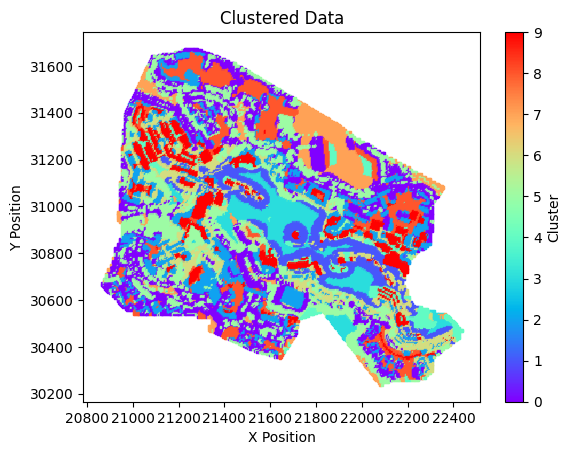

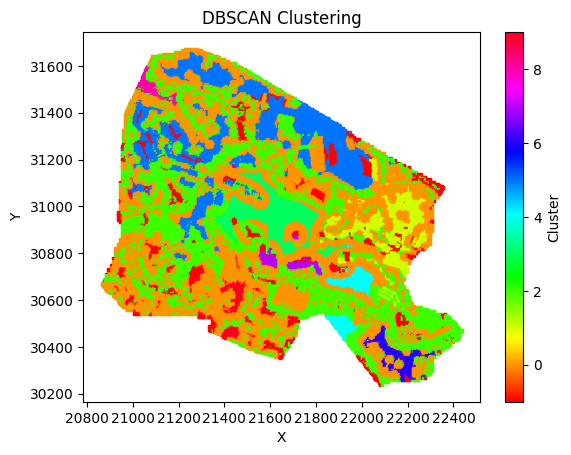

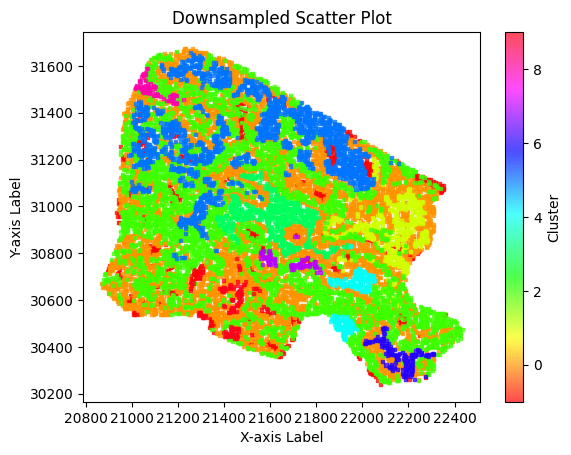

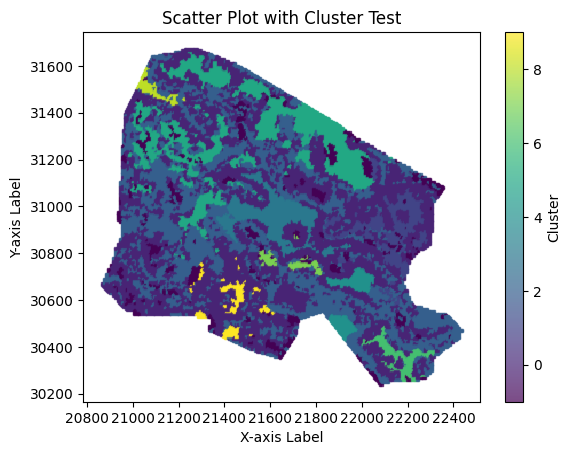

['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 'distToCourtTrack', 'distToCarpark', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height', 'cluster']


In [26]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = ['Bld_percent', 'distToBuilding', 'Bld_height', 'Veg_height', 'distToTree']


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 10
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()
#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.35
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


### Regression Kriging

['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 'distToCourtTrack', 'distToCarpark', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height', 'cluster']
2024-02-11 16:31:00+08:00
[[21090.2765864  31446.60822025]
 [21018.30142651 31316.75082108]
 [21066.83503539 31298.58216171]
 [21039.58970296 31247.48616768]
 [21036.02665216 31177.43704883]
 [20997.72046822 31187.01378697]
 [21256.09649267 31289.07917335]
 [21315.79795824 31495.28889485]
 [21464.10080305 31340.67956935]
 [21255.13412191 31069.35579655]
 [21224.08197261 30990.33971316]
 [21131.70569342 30803.75784993]
 [21109.82313757 30693.89115554]
 [20960.70207937 30623.35909941]
 [21294.58061741 30807.10435116]
 [21432.48679    30548.11257404]
 [21455.76841863 30524.99082251]
 [21475.88698012 30879.86944249]
 [21626.52801044 30753.76638277]
 [21961.7339809  30589.69904446]
 [22166.8294888  30425.38045327]
 [22160.60736682 30380.33237296]
 [22176.9094733

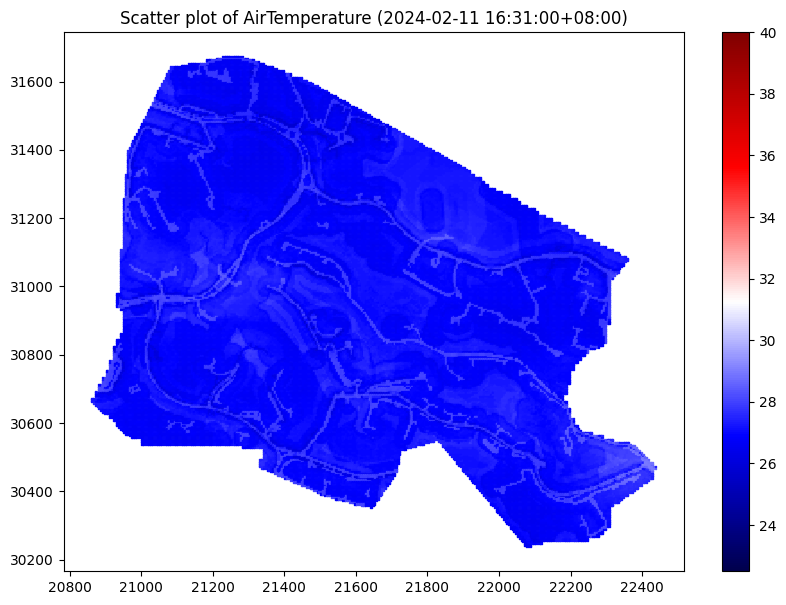

In [28]:
### Select features for model
measure = "AirTemperature"
# minval = df.drop(columns=['Lat','Lon']).min(numeric_only=True).min()
# maxval = df.drop(columns=['Lat','Lon']).max(numeric_only=True).max()
minval = 22.5
maxval = 40

print(features)
p = wsdf[features]
target_p = griddf[features]
target_x = np.array(list(zip(griddf.X, griddf.Y)))

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])
print("=" * 40)

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['#linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

### List of month names
times = ['2024-02-11 16:31:00+08:00']
dt = datetime.fromisoformat(times[0])
filename = dt.strftime('%Y-%m-%d_%H-%M-%S_%z')

for k in variogram_models:
    model = RandomForestRegressor(n_estimators=15, random_state=random_state)

    scores_mths = []
    for mth in times:
        print(mth)

        x = np.array(list(zip(wsdf.X, wsdf.Y)))
        print(x)
        if mth in df.columns:
            target = df[mth].dropna()
            x = x[:len(target)]  # Ensure x and target have the same length

            # Convert target to numpy array
            target = np.array(target)
        else:
            print(f"Column {mth} does not exist in the dataframe.")
            continue

        # target = np.array(df[mth])

        print("=" * 40)
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

        print(x)
        print(p)

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        resultdf = griddf
        resultdf[measure] = result

        ### Plot map (uncomment and adjust vmin, vmax and ticks if needed)
        plt.figure(figsize=(10, 7))
        plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
        plt.title('Scatter plot of '+ measure +' (' + mth + ')')
        cbar = plt.colorbar()
        # ticks = [14.0,16.5,19.0,21.5,24.0,26.5,29.0,31.5]
        # cbar.set_ticks(ticks)
        # cbar.set_ticklabels(ticks)

        ### Print results to csv per month (uncomment to save csv and png)
        if not os.path.exists(dirOut + today):
            os.makedirs(dirOut + today)
        resultdf.to_csv(dirOut + today + '/' + measure + filename + '.csv')
        plt.savefig(dirOut + today + '/' + measure + filename + '.png', bbox_inches='tight')
        plt.show()

        ### Extract feature importances (uncomment to display feature importances)
        feature_importance_df[mth] = m_rk.regression_model.feature_importances_
        # featuredf = pd.DataFrame(list(zip(m_rk.regression_model.feature_names_in_, m_rk.regression_model.feature_importances_)), columns =['FeatureName', 'FeatureImportance'])
        # display(featuredf.sort_values(by=['FeatureImportance'], ascending=False))

### Feature Importance

FeatureName  2024-02-11 16:31:00+08:00      mean
0     distToBuilding                   0.179239  0.179239
1         distToTree                   0.021925  0.021925
2      distToWalkway                   0.230084  0.230084
3         distToRoad                   0.284920  0.284920
4         distToPath                   0.021075  0.021075
5   distToCourtTrack                   0.094411  0.094411
6      distToCarpark                   0.013979  0.013979
7              Sun_h                   0.007668  0.007668
8          Bld_SkyEx                   0.025237  0.025237
9          Veg_SkyEx                   0.030072  0.030072
10        Veg_height                   0.017547  0.017547
11       Veg_percent                   0.008827  0.008827
12       Bld_percent                   0.008035  0.008035
13        Bld_height                   0.014369  0.014369
14        Ter_height                   0.020057  0.020057
15           cluster                   0.022554  0.022554

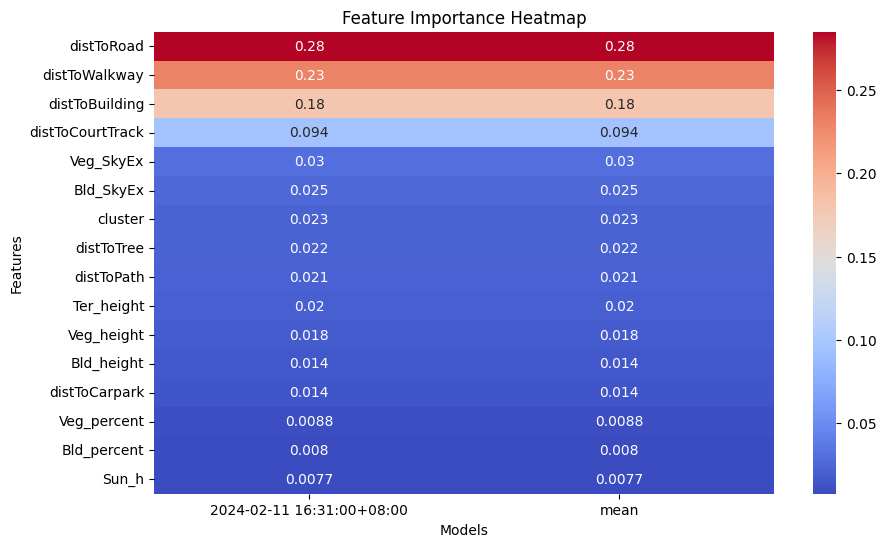

['distToRoad', 'distToWalkway', 'distToBuilding', 'distToCourtTrack', 'Veg_SkyEx', 'Bld_SkyEx']


In [36]:
display(feature_importance_df)
if 'FeatureName' not in feature_importance_df.columns:
    feature_importance_df.reset_index(inplace=True)

# Calculate the mean of only numeric columns
numeric_cols = feature_importance_df.select_dtypes(include='number').columns
feature_importance_df['mean'] = feature_importance_df[numeric_cols].mean(axis=1)

# Sort and set index for plotting
feature_plotheatmap = feature_importance_df.sort_values(by='mean', ascending=False).set_index('FeatureName')


plt.figure(figsize=(10, 6))
sns.heatmap(feature_plotheatmap, annot=True, cmap='coolwarm')
plt.title('Feature Importance Heatmap')
plt.xlabel('Models')
plt.ylabel('Features')
plt.show()

# plt.savefig(dirRP + today + '/' + 'FeatureMap' + '_' + measure + mth + '.png', bbox_inches='tight')

#select features based on threshhold
treshhold = 0.025
update_feature_selection = feature_plotheatmap[feature_plotheatmap['mean'] > treshhold].index.tolist()
print(update_feature_selection)